In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import gym
import random
from collections import deque
from tqdm import tqdm
import rl_utils

In [5]:
class QNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNet, self).__init__()
        self.fc1 = nn.Linear(state_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, action_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [6]:
class DQN:
    def __init__(self, state_dim, action_dim, target_update, device, gamma=0.99, lr=1e-3):
        self.device = device
        self.action_dim = action_dim
        self.gamma = gamma
        
        self.q_net = QNet(state_dim, action_dim).to(device)
        self.target_q_net = QNet(state_dim, action_dim).to(device)
        self.target_q_net.load_state_dict(self.q_net.state_dict())
        
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        
        self.target_update = target_update #Target network update interval. If target_update = t,then when q_net is updated t times, target_q_net is updated once
        self.count = 0 #Counter.  record q_net update times


    def take_action(self, state, epsilon):
        # epsilon-greedy
        ############################
        # YOUR IMPLEMENTATION HERE #
        ############################
        if np.random.random() < epsilon:
            # 随机选择动作
            return np.random.randint(0, self.action_dim)
        else:
            # 选择Q值最大的动作
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
            with torch.no_grad():
                q_values = self.q_net(state)
            return q_values.argmax().item()
        
    def update(self, replay_buffer, batch_size):
        states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
        
        states = torch.tensor(states, dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.int64).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).to(self.device)
        
        ############################
        # YOUR IMPLEMENTATION HERE #
        ############################
        # 计算当前Q值
        q_values = self.q_net(states)
        q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # 计算目标Q值
        with torch.no_grad():
            next_q_values = self.target_q_net(next_states)
            next_q_values = next_q_values.max(1)[0]
            target_q_values = rewards + self.gamma * next_q_values * (1 - dones)
        
        # 计算损失
        loss = nn.MSELoss()(q_values, target_q_values)
        
        # 优化模型
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # 更新目标网络
        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
            
        self.count += 1
        return loss.item()
    

In [7]:
# One-hot
def one_hot(state, state_dim):
    vec = np.zeros(state_dim, dtype=np.float32)
    vec[state] = 1.0
    return vec

In [10]:
env_name = "Taxi-v2"
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("cpu")
env = gym.make(env_name)
env.seed(0)
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)


obs_space = env.observation_space.n
action_space = env.action_space.n

# parameters
total_episodes = 5000
episodes_per_iteration = 100
iterations = total_episodes // episodes_per_iteration

batch_size = 64
buffer_size = 20000
min_buffer_size = 5000
epsilon_start = 1.0
epsilon_end = 0.1
epsilon_decay = 0.999  
update_freq = 1
target_update = 10

replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(obs_space, action_space, target_update, device, gamma=0.99, lr=0.0001)

return_list = []

epsilon = epsilon_start
total_steps = 0

# tqdm
for i_iter in range(iterations):
    with tqdm(range(episodes_per_iteration), desc=f"Iteration {i_iter}", ncols=100) as pbar:
        for i_episode_in_iter in pbar:
            i_episode = i_iter * episodes_per_iteration + i_episode_in_iter
            state = env.reset()
            state_vec = one_hot(state, obs_space)
            done = False
            episode_reward = 0
            episode_length = 0
            
            while not done:
                total_steps += 1
                episode_length += 1
                action = agent.take_action(state_vec, epsilon)
                next_state, reward, done, info = env.step(action)
                next_state_vec = one_hot(next_state, obs_space)
                
                replay_buffer.add(state_vec, action, reward, next_state_vec, done)
                state_vec = next_state_vec
                episode_reward += reward
                
                if replay_buffer.size() > min_buffer_size and total_steps % update_freq == 0:
                    loss = agent.update(replay_buffer, batch_size)
            
            epsilon = max(epsilon_end, epsilon * epsilon_decay)
            return_list.append(episode_reward)
    
    avg_return = np.mean(return_list[-episodes_per_iteration:])
    print(f"Episode: {(i_iter+1)*episodes_per_iteration}, Average Return: {avg_return:.2f}")


torch.save(agent.q_net.state_dict(), "dqn_taxi.pth")

/home/arno/conda/envs/gym_094/lib/python3.6/site-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
Iteration 0:   0%|                                                          | 0/100 [00:00<?, ?it/s]

Iteration 0: 100%|████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.45it/s]


Episode: 100, Average Return: -758.28


Iteration 1: 100%|████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


Episode: 200, Average Return: -562.37


Iteration 2: 100%|████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.58it/s]


Episode: 300, Average Return: -241.23


Iteration 3: 100%|████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.81it/s]


Episode: 400, Average Return: -132.59


Iteration 4: 100%|████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.77it/s]


Episode: 500, Average Return: -90.87


Iteration 5: 100%|████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.03it/s]


Episode: 600, Average Return: -58.99


Iteration 6: 100%|████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.59it/s]


Episode: 700, Average Return: -47.62


Iteration 7: 100%|████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.20it/s]


Episode: 800, Average Return: -37.84


Iteration 8: 100%|████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.99it/s]


Episode: 900, Average Return: -28.87


Iteration 9: 100%|████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.27it/s]


Episode: 1000, Average Return: -25.06


Iteration 10: 100%|███████████████████████████████████████████████| 100/100 [00:11<00:00,  8.76it/s]


Episode: 1100, Average Return: -17.83


Iteration 11: 100%|███████████████████████████████████████████████| 100/100 [00:10<00:00,  9.26it/s]


Episode: 1200, Average Return: -13.17


Iteration 12: 100%|███████████████████████████████████████████████| 100/100 [00:10<00:00,  9.31it/s]


Episode: 1300, Average Return: -10.62


Iteration 13: 100%|███████████████████████████████████████████████| 100/100 [00:10<00:00, 10.00it/s]


Episode: 1400, Average Return: -6.35


Iteration 14: 100%|███████████████████████████████████████████████| 100/100 [00:09<00:00, 10.24it/s]


Episode: 1500, Average Return: -6.88


Iteration 15: 100%|███████████████████████████████████████████████| 100/100 [00:10<00:00,  9.88it/s]


Episode: 1600, Average Return: -4.72


Iteration 16: 100%|███████████████████████████████████████████████| 100/100 [00:09<00:00, 10.45it/s]


Episode: 1700, Average Return: -3.64


Iteration 17: 100%|███████████████████████████████████████████████| 100/100 [00:09<00:00, 10.99it/s]


Episode: 1800, Average Return: -0.77


Iteration 18: 100%|███████████████████████████████████████████████| 100/100 [00:09<00:00, 10.48it/s]


Episode: 1900, Average Return: -0.47


Iteration 19: 100%|███████████████████████████████████████████████| 100/100 [00:09<00:00, 10.98it/s]


Episode: 2000, Average Return: 1.50


Iteration 20: 100%|███████████████████████████████████████████████| 100/100 [00:08<00:00, 11.16it/s]


Episode: 2100, Average Return: 2.24


Iteration 21: 100%|███████████████████████████████████████████████| 100/100 [00:08<00:00, 11.55it/s]


Episode: 2200, Average Return: 2.94


Iteration 22: 100%|███████████████████████████████████████████████| 100/100 [00:09<00:00, 10.93it/s]


Episode: 2300, Average Return: 2.64


Iteration 23: 100%|███████████████████████████████████████████████| 100/100 [00:08<00:00, 11.32it/s]


Episode: 2400, Average Return: 3.49


Iteration 24: 100%|███████████████████████████████████████████████| 100/100 [00:08<00:00, 11.24it/s]


Episode: 2500, Average Return: 3.74


Iteration 25: 100%|███████████████████████████████████████████████| 100/100 [00:08<00:00, 11.28it/s]


Episode: 2600, Average Return: 3.18


Iteration 26: 100%|███████████████████████████████████████████████| 100/100 [00:09<00:00, 11.07it/s]


Episode: 2700, Average Return: 4.35


Iteration 27: 100%|███████████████████████████████████████████████| 100/100 [00:09<00:00, 10.69it/s]


Episode: 2800, Average Return: 1.70


Iteration 28: 100%|███████████████████████████████████████████████| 100/100 [00:08<00:00, 11.33it/s]


Episode: 2900, Average Return: 3.68


Iteration 29: 100%|███████████████████████████████████████████████| 100/100 [00:09<00:00, 10.75it/s]


Episode: 3000, Average Return: 2.99


Iteration 30: 100%|███████████████████████████████████████████████| 100/100 [00:09<00:00, 10.87it/s]


Episode: 3100, Average Return: 3.24


Iteration 31: 100%|███████████████████████████████████████████████| 100/100 [00:09<00:00, 10.46it/s]


Episode: 3200, Average Return: 2.78


Iteration 32: 100%|███████████████████████████████████████████████| 100/100 [00:09<00:00, 10.77it/s]


Episode: 3300, Average Return: 3.05


Iteration 33: 100%|███████████████████████████████████████████████| 100/100 [00:09<00:00, 11.08it/s]


Episode: 3400, Average Return: 3.67


Iteration 34: 100%|███████████████████████████████████████████████| 100/100 [00:09<00:00, 10.59it/s]


Episode: 3500, Average Return: 3.23


Iteration 35: 100%|███████████████████████████████████████████████| 100/100 [00:09<00:00, 10.66it/s]


Episode: 3600, Average Return: 3.11


Iteration 36: 100%|███████████████████████████████████████████████| 100/100 [00:09<00:00, 10.55it/s]


Episode: 3700, Average Return: 2.82


Iteration 37: 100%|███████████████████████████████████████████████| 100/100 [00:09<00:00, 10.40it/s]


Episode: 3800, Average Return: 3.17


Iteration 38: 100%|███████████████████████████████████████████████| 100/100 [00:09<00:00, 10.46it/s]


Episode: 3900, Average Return: 3.49


Iteration 39: 100%|███████████████████████████████████████████████| 100/100 [00:09<00:00, 10.66it/s]


Episode: 4000, Average Return: 3.32


Iteration 40: 100%|███████████████████████████████████████████████| 100/100 [00:09<00:00, 10.17it/s]


Episode: 4100, Average Return: 1.90


Iteration 41: 100%|███████████████████████████████████████████████| 100/100 [00:09<00:00, 10.90it/s]


Episode: 4200, Average Return: 4.00


Iteration 42: 100%|███████████████████████████████████████████████| 100/100 [00:10<00:00,  9.99it/s]


Episode: 4300, Average Return: 3.44


Iteration 43: 100%|███████████████████████████████████████████████| 100/100 [00:09<00:00, 10.79it/s]


Episode: 4400, Average Return: 3.06


Iteration 44: 100%|███████████████████████████████████████████████| 100/100 [00:09<00:00, 10.60it/s]


Episode: 4500, Average Return: 3.45


Iteration 45: 100%|███████████████████████████████████████████████| 100/100 [00:09<00:00, 10.21it/s]


Episode: 4600, Average Return: 2.41


Iteration 46: 100%|███████████████████████████████████████████████| 100/100 [00:09<00:00, 10.55it/s]


Episode: 4700, Average Return: 3.85


Iteration 47: 100%|███████████████████████████████████████████████| 100/100 [00:09<00:00, 10.37it/s]


Episode: 4800, Average Return: 2.27


Iteration 48: 100%|███████████████████████████████████████████████| 100/100 [00:09<00:00, 10.59it/s]


Episode: 4900, Average Return: 3.76


Iteration 49: 100%|███████████████████████████████████████████████| 100/100 [00:09<00:00, 10.29it/s]

Episode: 5000, Average Return: 2.82


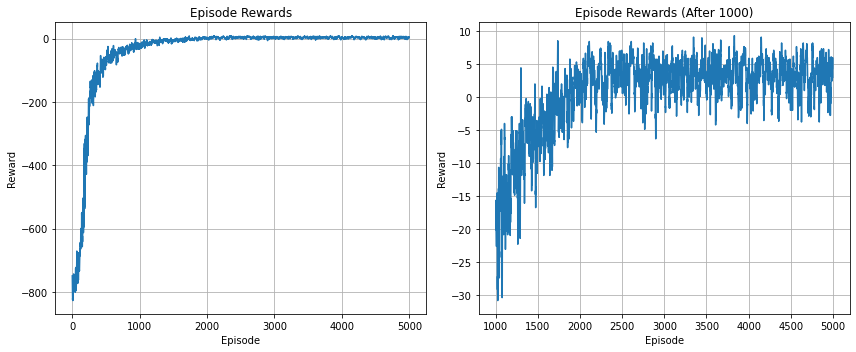

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 改为1行2列，并调整整体宽度

# 左图 - 完整数据
axes[0].plot(mv_return)
axes[0].set_title("Episode Rewards")
axes[0].set_xlabel("Episode")
axes[0].set_ylabel("Reward")
axes[0].grid(True)

# 右图 - 1000集之后的数据
axes[1].plot(range(1000, 1000 + len(mv_return[1000:])), mv_return[1000:])  # 使用正确的x轴范围
axes[1].set_title("Episode Rewards (After 1000)")
axes[1].set_xlabel("Episode")
axes[1].set_ylabel("Reward")
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
le